Created by Paul A. Gureghian in April 2022.

# Project: Identify Customer Segments

In this project, I will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that I will use has been provided by Bertelsmann Arvato Analytics, and represents real-life data.


In [1]:
# Import libraries.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Magic word for producing visualizations in notebook
%matplotlib inline


### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. I will use this information to cluster the general population into groups with similar demographic properties. Then, we will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, I will load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so I'll need an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, we will take a little bit of time just browsing the general structure of the dataset and feature summary file. I'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help me get my bearings.

In [2]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [3]:
# Load in the azdias demographics data.
azdias = '/content/drive/MyDrive/udacity_azdias_subset.csv'
azdias = pd.read_csv(azdias, delimiter=';')


# Load in the feature summary file.
feat_info = '/content/drive/MyDrive/azdias_feature_summary.csv'
feat_info = pd.read_csv(feat_info, delimiter=';')


In [4]:
from numpy.ma.core import shape
# Check the structure of the data.
azdias


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,-1,3,2,5.0,1,4,2,5,4,4,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,-1,2,1,4.0,3,3,3,2,2,3,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,-1,2,2,4.0,2,4,2,5,4,3,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,-1,1,1,3.0,1,5,3,5,5,5,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0


In [5]:
# Print the shape.
shape(azdias)


(85, 891221)

In [6]:
# Description.
azdias.describe()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [7]:
# Check the strucure of the data.
feat_info


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
...,...,...,...,...
80,PLZ8_HHZ,macrocell_plz8,ordinal,[-1]
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1]
82,ARBEIT,community,ordinal,"[-1,9]"
83,ORTSGR_KLS9,community,ordinal,"[-1,0]"


In [8]:
# Print the shape.
shape(feat_info)


(4, 85)

In [9]:
# Description.
feat_info.describe()


,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,AGER_TYP,person,ordinal,[-1]
freq,1,43,49,26


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. I will use this file to help me make cleaning decisions during this stage of the project. First of all, I will assess the demographics data in terms of missing data. I will pay attention to the following points as I perform my analysis, and take notes on what I observe. 

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. I'll need to do a little bit of parsing to make use of it to identify and clean the data. I will convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. I will want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.


In [10]:
# Number of naturally missing data.
azdias.isnull().sum().sum()

4896838

In [11]:
# Make cleaning decisions with the summary feature file.
for i in range(feat_info.shape[0]):

  print("The contents of i: ", i, '\n')
  
  category = feat_info.iloc[i]['attribute']
  print("The contents of category: ", category, '\n')
  
  missing_list = feat_info.iloc[i]['missing_or_unknown'][1:-1].split(',')
  print("The contents of missing list: ", missing_list, '\n')

  if missing_list[0] == '':
      continue

  for j in range(len(missing_list)):
    
    print("The contents of j: ", j, '\n')

    if missing_list[j] not in ['XX', 'X']:
         missing_list[j] = int(missing_list[j])
  print("The final missing list contents: ", missing_list, '\n','\n')
  
  # Convert missing data to NaNs.
  azdias[category].replace(missing_list, np.nan, inplace=True) 


The contents of i:  0 

The contents of category:  AGER_TYP 

The contents of missing list:  ['-1', '0'] 

The contents of j:  0 

The contents of j:  1 

The final missing list contents:  [-1, 0] 
 

The contents of i:  1 

The contents of category:  ALTERSKATEGORIE_GROB 

The contents of missing list:  ['-1', '0', '9'] 

The contents of j:  0 

The contents of j:  1 

The contents of j:  2 

The final missing list contents:  [-1, 0, 9] 
 

The contents of i:  2 

The contents of category:  ANREDE_KZ 

The contents of missing list:  ['-1', '0'] 

The contents of j:  0 

The contents of j:  1 

The final missing list contents:  [-1, 0] 
 

The contents of i:  3 

The contents of category:  CJT_GESAMTTYP 

The contents of missing list:  ['0'] 

The contents of j:  0 

The final missing list contents:  [0] 
 

The contents of i:  4 

The contents of category:  FINANZ_MINIMALIST 

The contents of missing list:  ['-1'] 

The contents of j:  0 

The final missing list contents:  [-1] 
 

Th

In [12]:
# Print the cleaned demographics data file.
print("The number of missing data: ", azdias.isnull().sum().sum(), '\n')
print("The cleaned demographics data file: ", '\n')
azdias


The number of missing data:  8373929 

The cleaned demographics data file:  



,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,NaN,3.0,2,5.0,1,4,2,5,4,4,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,NaN,2.0,1,4.0,3,3,3,2,2,3,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,NaN,2.0,2,4.0,2,4,2,5,4,3,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,NaN,1.0,1,3.0,1,5,3,5,5,5,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. I will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project I should just remove them from the dataframe. 

For the remaining features, are there any patterns in which columns have, or share, missing data?



In [13]:
# Assess how much missing data in each column of the demographics data file.
missing_data = azdias.isnull().sum()
print("The number of missing data in each column: ",'\n')
print(missing_data, '\n')
total_num_cols = (len(missing_data))

missing_data_greater_than_0 = missing_data[missing_data > 0]
print("The columns with more than 0 missing data points in a field: ", '\n')
print(missing_data_greater_than_0, '\n')
total_num_cols_greater_than_0 = len(missing_data_greater_than_0)


The number of missing data in each column:  

AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97375
ORTSGR_KLS9              97274
RELAT_AB                 97375
Length: 85, dtype: int64 

The columns with more than 0 missing data points in a field:  

AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
CJT_GESAMTTYP             4854
GEBURTSJAHR             392318
GFK_URLAUBERTYP           4854
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97375
ORTSGR_KLS9              97274
RELAT_AB                 97375
Length: 61, dtype: int64 



In [14]:
# Total number of columns 
print("The total number of columns: " , total_num_cols)


The total number of columns:  85


In [15]:
# The total number of columns with more than 0.
print("The number of columns with more than 0: ", total_num_cols_greater_than_0)


The number of columns with more than 0:  61


In [16]:
# Percentage of missing data per col.
missing_pct = missing_data / (azdias.shape[0]) * 100
print("Percentage of missing data per column: ", '\n')
missing_pct


Percentage of missing data per column:  



AGER_TYP                76.955435
ALTERSKATEGORIE_GROB     0.323264
ANREDE_KZ                0.000000
CJT_GESAMTTYP            0.544646
FINANZ_MINIMALIST        0.000000
                          ...    
PLZ8_HHZ                13.073637
PLZ8_GBZ                13.073637
ARBEIT                  10.926022
ORTSGR_KLS9             10.914689
RELAT_AB                10.926022
Length: 85, dtype: float64

In [17]:
# Sort missing data > 0.
missing_data_greater_than_0.sort_values(inplace=True)
print("Sorted missing data > 0: ",'\n')
missing_data_greater_than_0 


Sorted missing data > 0:  



ALTERSKATEGORIE_GROB      2881
CJT_GESAMTTYP             4854
GFK_URLAUBERTYP           4854
ONLINE_AFFINITAET         4854
RETOURTYP_BK_S            4854
                         ...  
GEBURTSJAHR             392318
KBA05_BAUMAX            476524
KK_KUNDENTYP            584612
AGER_TYP                685843
TITEL_KZ                889061
Length: 61, dtype: int64

In [18]:
# Sort missing data pct.
missing_pct.sort_values(inplace=True)
print("Sorted missing data pct: ", '\n')
missing_pct
 

Sorted missing data pct:  



ZABEOTYP          0.000000
SEMIO_TRADV       0.000000
SEMIO_PFLICHT     0.000000
SEMIO_KAEM        0.000000
SEMIO_DOM         0.000000
                   ...    
GEBURTSJAHR      44.020282
KBA05_BAUMAX     53.468668
KK_KUNDENTYP     65.596749
AGER_TYP         76.955435
TITEL_KZ         99.757636
Length: 85, dtype: float64

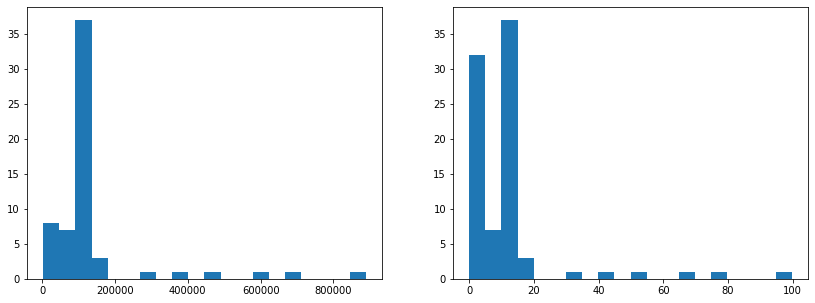

In [19]:
# Plot the missing data values > 0
# Plot the missing data values pct.
plt.figure(figsize=[14, 5])

plt.subplot(1, 2, 1)
plt.hist(missing_data_greater_than_0, bins=20);

plt.subplot(1 ,2 ,2)
plt.hist(missing_pct, bins=20);


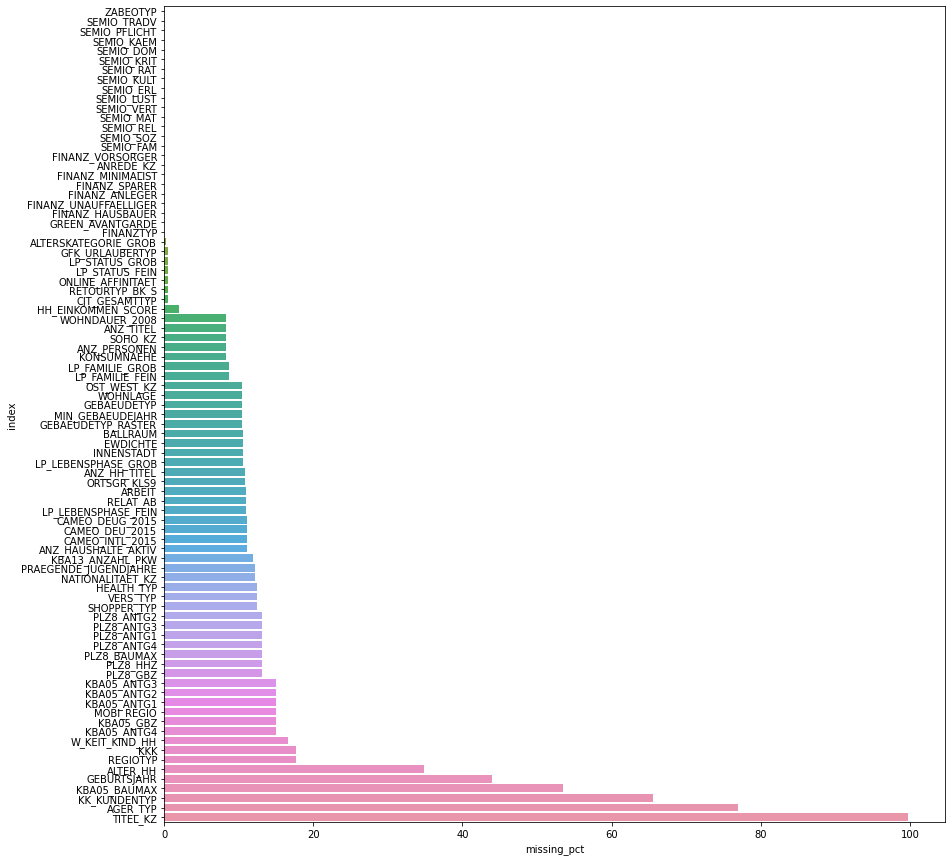

In [20]:
# Plot the amount of missing data in each column.
plt.figure(figsize=[14, 15])

missing_pct_df = pd.DataFrame(missing_pct, columns=['missing_pct'])
missing_pct_df.reset_index(inplace=True)

sns.barplot(y=missing_pct_df['index'], x=missing_pct_df['missing_pct'])


In [21]:
# Seperate cols with >20% missing data. 
drop_cols = missing_pct_df[missing_pct_df['missing_pct'] > 20 ]
print("Cols to be dropped: ", '\n')
print(drop_cols, '\n')

# Drop the cols.
azdias.drop(drop_cols['index'].values, axis=1, inplace=True)

# Print the cleaned and reduced demographics data file.
print("The cleaned and reduced demographics data file: ", '\n')
azdias


Cols to be dropped:  

           index  missing_pct
79      ALTER_HH    34.813699
80   GEBURTSJAHR    44.020282
81  KBA05_BAUMAX    53.468668
82  KK_KUNDENTYP    65.596749
83      AGER_TYP    76.955435
84      TITEL_KZ    99.757636 

The cleaned and reduced demographics data file:  



,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,3.0,2,5.0,1,4,2,5,4,4,1,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,2.0,1,4.0,3,3,3,2,2,3,6,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,2.0,2,4.0,2,4,2,5,4,3,1,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,1.0,1,3.0,1,5,3,5,5,5,1,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

I dropped the last 6 columns because up to that point the pct of missing data was a little under 18%, then it jumped to 34%. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, I'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, I should see some groups of points that have a very different numbers of missing values. I will divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, I should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- I will use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, I might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what I observe in my comparison, this will have implications on how I approach my conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then I could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then I should make a note on those data as special. I'll revisit these data later on. **Either way, I should continue my analysis for now using just the subset of the data with few or no missing values.**


In [22]:
# Calculate missing data in each row of the dataset.
missing_data_row = azdias.isnull().sum(axis=1)
print("Missing data in rows: ", '\n')
missing_data_row


Missing data in rows:  



0         43
1          0
2          0
3          7
4          0
          ..
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

In [23]:
# Print sorted rows with >0 missing values.
rows_greater_than_0_missing_values = missing_data_row[missing_data_row > 0]
rows_greater_than_0_missing_values.sort_values(inplace=True)

print("Sorted rows with >0 missing values: ", '\n')
rows_greater_than_0_missing_values


Sorted rows with >0 missing values:  



237075     1
736043     1
768679     1
736038     1
736034     1
          ..
604314    47
604334    47
472919    48
643174    49
732775    49
Length: 268012, dtype: int64

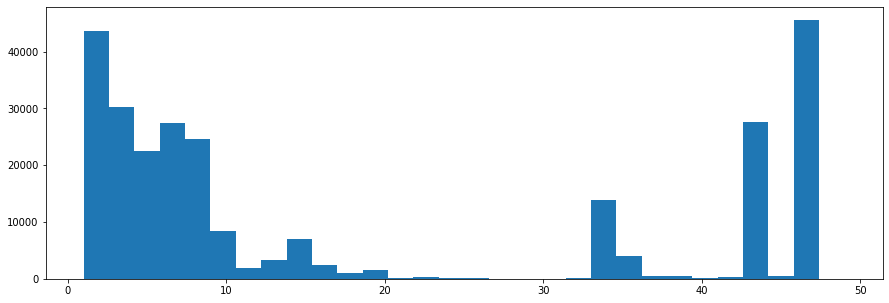

In [24]:
# Plot the sorted missing row values.
plt.figure(figsize=[15, 5])
plt.hist(rows_greater_than_0_missing_values, bins=30);


In [25]:
# Divide the data into two subsets based on the number of missing values per row.
below_threshold = rows_greater_than_0_missing_values[rows_greater_than_0_missing_values <= 10.0]
above_threshold = rows_greater_than_0_missing_values[rows_greater_than_0_missing_values >10.0]


In [26]:
# Print shape of below threshold set. 
print("The below threshold set shape: ")
below_threshold.shape


The below threshold set shape: 


(156944,)

In [27]:
# Print shape of above threshold set.
print("The above threshold set shape: ")
above_threshold.shape


The above threshold set shape: 


(111068,)

In [28]:
# Create the 2 subsets.
azdias_above_threshold = azdias.drop(below_threshold.index, axis=0)
azdias_below_threshold = azdias.drop(above_threshold.index, axis=0)


In [29]:
# Print above threshold dataset.
print("Above threshold dataset: ", '\n')
azdias_above_threshold


Above threshold dataset:  



,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891213,4.0,2,5.0,3,3,3,5,3,2,6,...,2.0,4.0,2.0,1.0,2.0,5.0,5.0,3.0,4.0,4.0
891214,1.0,2,4.0,1,5,2,3,3,4,1,...,1.0,4.0,3.0,2.0,5.0,5.0,2.0,3.0,7.0,3.0
891215,2.0,2,6.0,1,5,2,4,5,4,1,...,2.0,4.0,2.0,1.0,2.0,4.0,4.0,2.0,5.0,2.0
891219,1.0,1,3.0,1,5,3,5,5,5,1,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0


In [30]:
# Print below threshold dataset.
print("Below threshold dataset: ", '\n')
azdias_below_threshold


Below threshold dataset:  



,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,3.0,2,5.0,1,4,2,5,4,4,1,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,2.0,1,4.0,3,3,3,2,2,3,6,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,2.0,2,4.0,2,4,2,5,4,3,1,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,1.0,1,3.0,1,5,3,5,5,5,1,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0


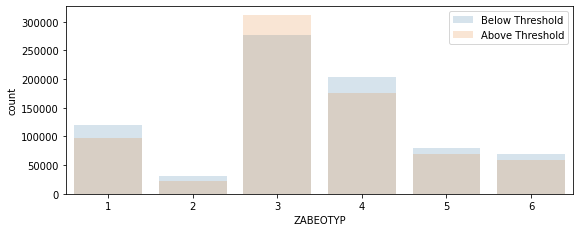

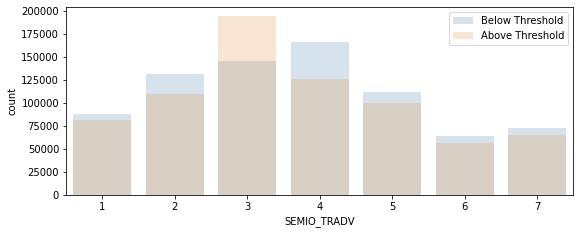

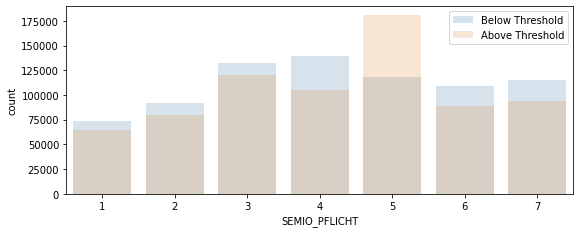

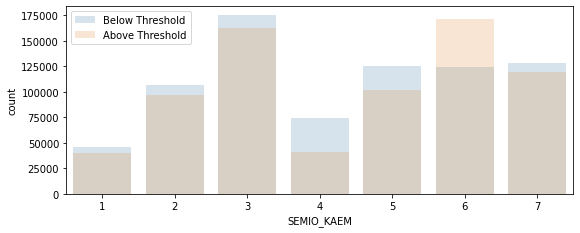

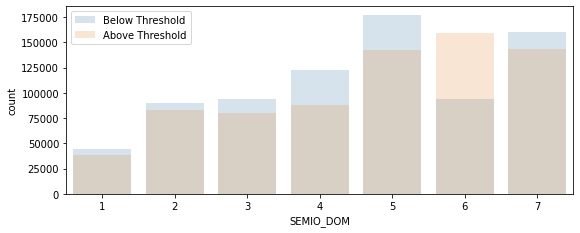

In [31]:
# The distribution of values for five columns for no / few missing values.
c1 = sns.color_palette()[0]
c2 = sns.color_palette()[1]
def compare_cols(col, i):

  plt.figure(figsize=[20, 20])
  plt.subplot(5 ,2, i)

  sns.countplot(x=azdias_below_threshold[col], color=c1, alpha=0.2)
  sns.countplot(x=azdias_above_threshold[col], color=c2, alpha=0.2)

  plt.legend(['Below Threshold', 'Above Threshold'])

# Call the 'compare_cols' function.
compare_cols('ZABEOTYP', 1)
compare_cols('SEMIO_TRADV', 2)
compare_cols('SEMIO_PFLICHT', 3)
compare_cols('SEMIO_KAEM', 4)
compare_cols('SEMIO_DOM', 5)  


#### Discussion 1.1.3: Assess Missing Data in Each Row

For the five columns I chose, all of which had 0 missing values, the majority  of its rows are below the threshold. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which I can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, I need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, I will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether I will keep, drop, or re-encode each. Then, in the last part, I will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here and once I am done with this step, I'll be ready to get to the machine learning parts of the project.

In [32]:
# How many features are there of each data type?
print("Value counts for each data type in feature summary file: ", '\n')
feat_info['type'].value_counts()


Value counts for each data type in feature summary file:  



ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, I would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, I will perform one of the following:
- For binary (two-level) categoricals that take numeric values, I can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, I need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), I can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, I document my choices in the Discussion section.

In [33]:
# Store and print categorical type column names .
categorical_type = feat_info[feat_info['type'] == 'categorical']
print("Columns of categorical type: ", '\n')
categorical_type


Columns of categorical type:  



,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


In [34]:
# Store and print mixed type column names.
mixed_type = feat_info[feat_info['type'] == 'mixed']
print("Columns of mixed type: ", '\n')
mixed_type


Columns of mixed type:  



,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [35]:
# Store and print categorical type column names
# In the below threshold dataset.
categorical_type_below_threshold = feat_info[feat_info['type'] == 'categorical']

categorical_column_names = []

for category in categorical_type_below_threshold['attribute']:

  if category in azdias_below_threshold.columns:
    categorical_column_names.append(category)

print("Columns of categorical type: ", '\n')
categorical_column_names


Columns of categorical type:  



['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [36]:
# Store and print mixed type column names
# In the below threshold dataset
mixed_type_below_threshold = feat_info[feat_info['type'] == 'mixed']

mixed_column_names = []

for mixed in mixed_type_below_threshold['attribute']:

  if mixed in azdias_below_threshold.columns:
    mixed_column_names.append(mixed)

print("Column names of mixed type: ", '\n')
mixed_column_names


Column names of mixed type:  



['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [37]:
# Which categorical columns need to be re-encoded.
print("Print unique column values: ", '\n')
for col_name in azdias_below_threshold[categorical_column_names].columns:

  print(col_name)
  print(azdias_below_threshold[col_name].unique())


Print unique column values:  

ANREDE_KZ
[2 1]
CJT_GESAMTTYP
[ 5.  3.  2.  4.  1.  6. nan]
FINANZTYP
[1 6 5 2 4 3]
GFK_URLAUBERTYP
[10.  1.  5. 12.  9.  3.  8. 11.  4.  7.  2.  6. nan]
GREEN_AVANTGARDE
[0 1]
LP_FAMILIE_FEIN
[ 5.  1. nan 10.  2.  7. 11.  8.  4.  6.  9.  3.]
LP_FAMILIE_GROB
[ 3.  1. nan  5.  2.  4.]
LP_STATUS_FEIN
[ 2.  3.  9.  4.  1. 10.  5.  8.  6.  7. nan]
LP_STATUS_GROB
[ 1.  2.  4.  5.  3. nan]
NATIONALITAET_KZ
[ 1.  3.  2. nan]
SHOPPER_TYP
[ 3.  2.  1.  0. nan]
SOHO_KZ
[1. 0.]
VERS_TYP
[ 2.  1. nan]
ZABEOTYP
[5 3 4 1 6 2]
GEBAEUDETYP
[8. 1. 3. 2. 6. 4. 5.]
OST_WEST_KZ
['W' 'O']
CAMEO_DEUG_2015
['8' '4' '2' '6' '1' '9' '5' '7' '3' nan]
CAMEO_DEU_2015
['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' nan '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']


In [38]:
# Drop categorical columns.
multilevel_non_numeric_cols = ['VERS_TYP','CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
                               'NATIONALITAET_KZ', 'GEBAEUDETYP', 'CAMEO_DEU_2015', 'LP_FAMILIE_GROB', 
                               'LP_FAMILIE_FEIN', 'SHOPPER_TYP', 'CAMEO_DEUG_2015', 'ZABEOTYP', 'FINANZTYP']

azdias = azdias_below_threshold.drop(multilevel_non_numeric_cols, axis=1);

azdias 

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,1,5,2,5,4,5,0,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,3.0,2,1,4,2,5,4,4,0,3.0,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,2.0,1,3,3,3,2,2,3,0,NaN,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,2.0,2,2,4,2,5,4,3,0,1.0,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,1.0,1,1,5,3,5,5,5,0,1.0,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0


In [39]:
# Binary encode columns.
azdias['ANREDE_KZ'] = azdias['ANREDE_KZ'].map({0:1, 2:1})
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].map({'W':0, 'O':1})
azdias['SOHO_KZ'] = azdias['SOHO_KZ'].map({0:1, 1.:0.})

azdias


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,1.0,1,5,2,5,4,5,0,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,1.0,1,4,1,2,3,5,1,3.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,1.0,4,2,5,2,1,2,0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,NaN,4,3,4,1,3,2,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,1.0,3,1,5,2,2,5,0,3.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,3.0,1.0,1,4,2,5,4,4,0,3.0,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,2.0,NaN,3,3,3,2,2,3,0,NaN,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,2.0,1.0,2,4,2,5,4,3,0,1.0,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,1.0,NaN,1,5,3,5,5,5,0,1.0,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0


#### Discussion 1.2.1: Re-Encode Categorical Features

I dropped 14 columns because they were mutli-level and mixed with different values.

I binary encoded 3 columns because they had binary values.

I kept 1 column because it had proper binary values.

I was going to onehotencode a couple of the multi-level cols which had proper integers but decided against it.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to my own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, I should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If I decide to keep or engineer new features around the other mixed-type features, I will make sure to note my steps in the Discussion section.

I will check the `Data_Dictionary.md` for the details needed to finish these engineering tasks.

In [40]:
# Analyze 'praegende_jugendjahre'.
print("Print unique column values: ", '\n')
for col_name in azdias[mixed_column_names].columns:

  print(col_name)
  print(azdias[col_name].unique())


Print unique column values:  

LP_LEBENSPHASE_FEIN
[21.  3. nan 32.  8.  2.  5. 10.  4.  6. 23. 12. 20.  1. 25. 13. 18. 31.
 38. 35. 30.  7. 22. 14. 29. 24. 28. 37. 26. 39. 27. 36.  9. 34. 33. 15.
 11. 40. 16. 19. 17.]
LP_LEBENSPHASE_GROB
[ 6.  1. nan 10.  2.  3.  5.  7. 12. 11.  9.  4.  8.]
PRAEGENDE_JUGENDJAHRE
[14. 15.  8.  3. 10. 11.  5.  9.  6.  4. nan  2.  1. 12. 13.  7.]
WOHNLAGE
[4. 2. 7. 3. 5. 1. 8. 0.]
CAMEO_INTL_2015
['51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25' nan
 '23' '31' '52' '35' '45' '44' '32']
PLZ8_BAUMAX
[ 1.  2. nan  4.  5.  3.]


In [41]:
# Engineer a binary var for 'praegende_jugendjahre'[movement].
def encode_movement_binary(x):

  mainstream = [1, 3, 5, 8, 10, 12, 14]
  avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]

  if x in mainstream:
    return 0

  elif x in avantgarde:
    return 1

# Call the function.
azdias['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(encode_movement_binary)    


In [42]:
# Engineer an interval-type var for 'praegende_jugendjahre'[decade].
def encode_decade_interval(x):

  intervals = { 0: [1, 2],
                1: [3, 4],
                2: [5, 6, 7],
                3: [8, 9],
                4: [10, 11, 12, 13],
                5: [14, 15]}  
              
  for i, values in intervals.items():
    if x in values:
      return i

# Call the function.
azdias['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(encode_decade_interval)


In [43]:
# Engineer an ordinal variable for 'cameo_intl_2015'[weatlh]
def encode_wealth(x):

    if pd.isnull(x):
      return np.nan
  
    else:
      return int(str(x)[0])  

# Call the function.
azdias['CAMEO_INTL_2015_WEALTH'] = azdias['CAMEO_INTL_2015'].apply(encode_wealth)


In [44]:
# Engineer an ordinal variable for 'cameo_intl_2015'[lifestage]
def encode_lifestage(x):

    if pd.isnull(x):
      return np.nan

    else:
      return int(str(x)[1])  

# Call the function.
azdias['CAMEO_INTL_2015_LIFESTAGE'] = azdias['CAMEO_INTL_2015'].apply(encode_lifestage)


In [45]:
# Drop mixed-type columns.
azdias = azdias.drop(mixed_column_names, axis=1)
azdias


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
1,1.0,1.0,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,0.0,5.0,5.0,1.0
2,3.0,1.0,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,1.0,5.0,2.0,4.0
3,4.0,1.0,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,0.0,3.0,1.0,2.0
4,3.0,NaN,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,0.0,3.0,4.0,3.0
5,1.0,1.0,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,0.0,1.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,3.0,1.0,1,4,2,5,4,4,0,3.0,...,0.0,2.0,3.0,NaN,NaN,NaN,0.0,5.0,4.0,1.0
891217,2.0,NaN,3,3,3,2,2,3,0,NaN,...,2.0,5.0,3.0,4.0,6.0,5.0,0.0,4.0,5.0,1.0
891218,2.0,1.0,2,4,2,5,4,3,0,1.0,...,0.0,3.0,4.0,2.0,2.0,3.0,0.0,5.0,2.0,4.0
891219,1.0,NaN,1,5,3,5,5,5,0,1.0,...,1.0,1.0,1.0,4.0,7.0,5.0,0.0,5.0,5.0,1.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

Out of the 6 mixed-type columns I had to analyze, I dropped them all, but not before I engineered 2 columns for one of them and 2 for another.

So, I dropped 6 unique cols and engineered 4 unique cols.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Step 1.3: Create a Cleaning Function

Even though I have finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that I'll need to perform the same cleaning steps on the customer demographics data. In this substep, I will write a function to execute the main feature selection, encoding, and re-engineering steps I performed above. Then, when it comes to looking at the customer data in Step 3, I can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [46]:
# Load in the udacity demographics data.
udacity = '/content/drive/MyDrive/udacity_customers_subset.csv'
udacity = pd.read_csv(udacity, delimiter=';')


In [47]:
# Check the structure of the data.
udacity


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191647,1,3,1,4.0,5,1,5,1,1,2,...,2.0,4.0,2.0,1.0,2.0,5.0,4.0,3.0,8.0,5.0
191648,-1,4,2,2.0,5,1,5,2,2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,1.0
191649,2,4,1,2.0,5,1,5,1,1,2,...,3.0,2.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0
191650,3,3,2,4.0,2,1,5,1,2,5,...,3.0,2.0,1.0,1.0,1.0,2.0,3.0,3.0,4.0,4.0


In [48]:
# Define the 'clean_data' function.
def clean_data(udacity):
    
    # For loop to assess and clean / convert missing data to NaNs.
    for i in range(feat_info.shape[0]):

      print("The contents of i: ", i, "\n")

      category = feat_info.iloc[i]['attribute']
      print("The contents of category: ", category, "\n")

      missing_data_list = feat_info.iloc[i]['missing_or_unknown'][1:-1].split(',')
      print("The contents of missing data list: ", missing_data_list, "\n")

      if missing_data_list[0] == '':
          continue

      for j in range(len(missing_data_list)):

        print("The contents of j: ", j, "\n")

        if missing_data_list[j] not in ['XX', 'X']:
             missing_data_list[j] = int(missing_data_list[j])

      print("The final missing list contents: ", missing_data_list, "\n", "\n")

      # Convert missing data to NaNs.
      udacity[category].replace(missing_data_list, np.nan, inplace=True)  

    # Drop selected cols.
    udacity.drop(drop_cols['index'].values, axis=1, inplace=True)   

    # Drop selected rows.
    missing_data_row = udacity.isnull().sum(axis=1)
    missing_data_row = missing_data_row[missing_data_row > 0]
    missing_data_row.sort_values(inplace=True)
    
    below_threshold = missing_data_row[missing_data_row <= 10.0]
    above_threshold = missing_data_row[missing_data_row > 10.0]

    udacity_below_threshold = udacity.drop(above_threshold.index, axis=0)
    udacity_above_threshold = udacity.drop(below_threshold.index, axis=0)
    
    # Select and binary re-encode cols.
    udacity_below_threshold.drop(multilevel_non_numeric_cols, axis=1, inplace=True)
    udacity_below_threshold['ANREDE_KZ'] = udacity_below_threshold['ANREDE_KZ'].map({0:1, 2:1})
    udacity_below_threshold['OST_WEST_KZ'] = udacity_below_threshold['OST_WEST_KZ'].map({'W':0, 'O':1})
    udacity_below_threshold['SOHO_KZ'] = udacity_below_threshold['SOHO_KZ'].map({0:1, 1.:0.})
    
    # Engineer mixed-type cols.
    udacity_below_threshold['PRAEGENDE_JUGENDJAHRE_MOVEMENT '] = udacity_below_threshold['PRAEGENDE_JUGENDJAHRE'].apply(encode_movement_binary)
    udacity_below_threshold['PRAEGENDE_JUGENDJAHRE_DECADE'] =udacity_below_threshold['PRAEGENDE_JUGENDJAHRE'].apply(encode_decade_interval)
    udacity_below_threshold['CAMEO_INTL_2015_WEALTH'] = udacity_below_threshold['CAMEO_INTL_2015'].apply(encode_wealth)
    udacity_below_threshold['CAMEO_INTL_2015_LIFESTAGE'] = udacity_below_threshold['CAMEO_INTL_2015'].apply(encode_lifestage)

    # Drop mixed-type cols.
    udacity = udacity_below_threshold.drop(mixed_column_names, axis=1)

    # Return the cleaned dataframe.
    print("Cleaning completed", "\n")
    return udacity
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before I apply dimensionality reduction techniques to the data, I need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, I'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help me navigate to all of the classes and functions that I'll need. In this substep, I'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to my data, I will make sure that I've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. I might also try a more complicated procedure where I temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data I have and what possible effects each approach might have on my analysis, and justify my decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is what I will use, scaling each feature to mean 0 and standard deviation 1.
- For these classes, I can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. I won't forget to keep the fit sklearn objects handy, since I'll be applying them to the customer demographics data towards the end of the project.

In [49]:
# Clean the dataframe of all NaN values with imputation transformer.
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

print("NaN values before imputing:  {}".format(azdias.isnull().sum().sum()))

azdias_imputed = pd.DataFrame(imp_mean.fit_transform(azdias))
azdias_imputed.columns = azdias.columns
azdias_imputed.index = azdias.index
azdias = azdias_imputed

print("NaN values after imputing: {}".format(azdias.isnull().sum().sum()))


NaN values before imputing:  868080
NaN values after imputing: 0


In [50]:
# Print imputed azdias dataset.
print("Print imputed azdias dataset: ", "\n")
azdias


Print imputed azdias dataset:  



,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
1,1.0,1.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.00000,...,1.0,5.0,4.0,3.000000,5.000000,4.000000,0.0,5.0,5.0,1.0
2,3.0,1.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.00000,...,0.0,4.0,4.0,3.000000,5.000000,2.000000,1.0,5.0,2.0,4.0
3,4.0,1.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.00000,...,0.0,3.0,4.0,2.000000,3.000000,3.000000,0.0,3.0,1.0,2.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.00000,...,1.0,3.0,3.0,4.000000,6.000000,5.000000,0.0,3.0,4.0,3.0
5,1.0,1.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.00000,...,1.0,5.0,5.0,2.000000,3.000000,3.000000,0.0,1.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,3.0,1.0,1.0,4.0,2.0,5.0,4.0,4.0,0.0,3.00000,...,0.0,2.0,3.0,3.174057,5.306636,3.079018,0.0,5.0,4.0,1.0
891217,2.0,1.0,3.0,3.0,3.0,2.0,2.0,3.0,0.0,2.20384,...,2.0,5.0,3.0,4.000000,6.000000,5.000000,0.0,4.0,5.0,1.0
891218,2.0,1.0,2.0,4.0,2.0,5.0,4.0,3.0,0.0,1.00000,...,0.0,3.0,4.0,2.000000,2.000000,3.000000,0.0,5.0,2.0,4.0
891219,1.0,1.0,1.0,5.0,3.0,5.0,5.0,5.0,0.0,1.00000,...,1.0,1.0,1.0,4.000000,7.000000,5.000000,0.0,5.0,5.0,1.0


In [51]:
# Feature scale the demographics dataframe.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias))
azdias_scaled.columns = azdias.columns
azdias_scaled.index = azdias.index
azdias = azdias_scaled


In [52]:
# Print cleaned and scaled dataframe.
azdias


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
1,-1.767099,0.0,-1.488140,1.539080,-1.045251,1.467273,0.980071,1.326876,-0.531199,1.078455,...,0.41488,1.432164,0.560535,-1.750584e-01,-1.335265e-01,6.792646e-01,-0.552603,1.169476,1.180325,-1.260258
2,0.198771,0.0,-1.488140,0.866538,-1.771610,-0.569041,0.262544,1.326876,1.882535,1.078455,...,-0.96719,0.399701,0.560535,-1.750584e-01,-1.335265e-01,-7.958228e-01,1.873182,1.169476,-0.871579,0.760774
3,1.181706,0.0,0.688928,-0.478545,1.133828,-0.569041,-1.172510,-0.817895,-0.531199,-0.276116,...,-0.96719,-0.632762,0.560535,-1.180812e+00,-1.004438e+00,-5.827910e-02,-0.552603,-0.225811,-1.555547,-0.586581
4,0.198771,0.0,0.688928,0.193996,0.407468,-1.247812,0.262544,-0.817895,-0.531199,1.078455,...,0.41488,-0.632762,-0.343723,8.306951e-01,3.019294e-01,1.416808e+00,-0.552603,-0.225811,0.496357,0.087097
5,-1.767099,0.0,-0.036761,-1.151087,1.133828,-0.569041,-0.454983,1.326876,-0.531199,1.078455,...,0.41488,1.432164,1.464792,-1.180812e+00,-1.004438e+00,-5.827910e-02,-0.552603,-1.621097,1.180325,0.760774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,0.198771,0.0,-1.488140,0.866538,-1.045251,1.467273,0.980071,0.611953,-0.531199,1.078455,...,-0.96719,-1.665225,-0.343723,4.466442e-16,3.867625e-16,-6.550704e-16,-0.552603,1.169476,0.496357,-1.260258
891217,-0.784164,0.0,-0.036761,0.193996,-0.318891,-0.569041,-0.454983,-0.102971,-0.531199,0.000000,...,1.79695,1.432164,-0.343723,8.306951e-01,3.019294e-01,1.416808e+00,-0.552603,0.471833,1.180325,-1.260258
891218,-0.784164,0.0,-0.762450,0.866538,-1.045251,1.467273,0.980071,-0.102971,-0.531199,-1.630686,...,-0.96719,-0.632762,0.560535,-1.180812e+00,-1.439894e+00,-5.827910e-02,-0.552603,1.169476,-0.871579,0.760774
891219,-1.767099,0.0,-1.488140,1.539080,-0.318891,1.467273,1.697599,1.326876,-0.531199,-1.630686,...,0.41488,-2.697688,-2.152238,8.306951e-01,7.373852e-01,1.416808e+00,-0.552603,1.169476,1.180325,-1.260258


### Discussion 2.1: Apply Feature Scaling

I used SimpleImputer from SKLearn to replace NaN values in the columns with mean values of the columns.

I used StandardScaler from SKLearn to transform the column values to 'mean 0' and 'standard deviation 1'

### Step 2.2: Perform Dimensionality Reduction

On my scaled data, I am now ready to apply dimensionality reduction techniques.

- I will use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, I should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- I will check out the ratio of variance explained by each principal component as well as the cumulative variance explained. I will plot the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what I find, I will select a value for the number of transformed features to retain for the clustering part of the project.
- Once I've made a choice for the number of components to keep, I will make sure to re-fit a PCA instance to perform the decided-on transformation.

In [53]:
# Apply PCA techniques to the azdias dataframe.
from sklearn.decomposition import PCA
pca = PCA()

pca.fit(azdias)

print("Print the variance ratio: ", "\n" )
pca.explained_variance_ratio_

Print the variance ratio:  



array([1.74739918e-01, 1.38069095e-01, 8.43769952e-02, 5.44071978e-02,
       3.90096666e-02, 3.28358398e-02, 2.84022693e-02, 2.54459818e-02,
       2.22887507e-02, 2.16333811e-02, 2.05773931e-02, 1.93789996e-02,
       1.82779212e-02, 1.79264866e-02, 1.69340739e-02, 1.63606801e-02,
       1.61203449e-02, 1.51352066e-02, 1.34906269e-02, 1.34473313e-02,
       1.25381978e-02, 1.21623918e-02, 1.20494474e-02, 1.11513261e-02,
       9.96781312e-03, 8.12194494e-03, 7.74465409e-03, 7.63560056e-03,
       7.42136916e-03, 7.08777000e-03, 6.74358524e-03, 6.73067364e-03,
       6.54256239e-03, 6.29435228e-03, 6.20145724e-03, 5.69108077e-03,
       5.12462592e-03, 5.06117021e-03, 4.66570406e-03, 4.41975494e-03,
       4.23677750e-03, 4.10750324e-03, 4.02169919e-03, 3.97224316e-03,
       3.52816026e-03, 3.34718596e-03, 3.28271680e-03, 3.11294079e-03,
       2.93804406e-03, 2.79226496e-03, 2.67641191e-03, 2.64691591e-03,
       2.43995242e-03, 2.29382750e-03, 2.24445996e-03, 2.00454049e-03,
      

In [54]:
# Print the singular values.
print("Print the singular values: ", "\n")
pca.singular_values_


Print the singular values:  



array([2.90724612e+03, 2.58424673e+03, 2.02021580e+03, 1.62223555e+03,
       1.37363661e+03, 1.26025898e+03, 1.17209350e+03, 1.10941834e+03,
       1.03831374e+03, 1.02293476e+03, 9.97656217e+02, 9.68169535e+02,
       9.40262546e+02, 9.31179330e+02, 9.05037265e+02, 8.89582873e+02,
       8.83024800e+02, 8.55618002e+02, 8.07796193e+02, 8.06498916e+02,
       7.78759388e+02, 7.66999767e+02, 7.63430140e+02, 7.34427608e+02,
       6.94361575e+02, 6.26780904e+02, 6.12049784e+02, 6.07725328e+02,
       5.99139226e+02, 5.85518396e+02, 5.71124988e+02, 5.70577974e+02,
       5.62548113e+02, 5.51774034e+02, 5.47687228e+02, 5.24666229e+02,
       4.97870989e+02, 4.94778942e+02, 4.75055478e+02, 4.62364872e+02,
       4.52692777e+02, 4.45732903e+02, 4.41052744e+02, 4.38332477e+02,
       4.13104464e+02, 4.02370059e+02, 3.98476253e+02, 3.88035238e+02,
       3.76977030e+02, 3.67505675e+02, 3.59800873e+02, 3.57812747e+02,
       3.43539291e+02, 3.33093466e+02, 3.29489567e+02, 3.11381748e+02,
      

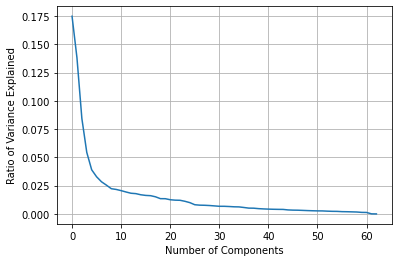

In [55]:
# Plot the variance ratio accounted for by each principal component.
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Ratio of Variance Explained')
plt.grid();


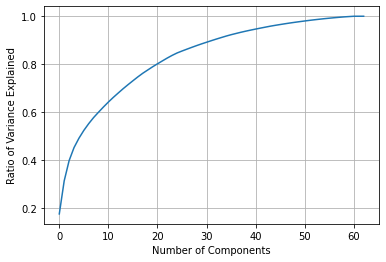

In [56]:
# Plot the cumulative variance ratio.
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Ratio of Variance Explained')
plt.grid();


In [57]:
# Re-apply PCA techniques to the dataframe with 'n_components' parameter.
pca = PCA(n_components=21)
azdias_pca = pca.fit_transform(azdias)
azdias_pca


array([[ 3.87347679e+00, -2.88044647e+00, -2.53230739e+00, ...,
         9.22525503e-01,  1.57269901e-01, -1.59452946e+00],
       [-9.35461083e-01, -3.68845667e-03, -2.90090036e+00, ...,
        -9.51287328e-01,  9.42156247e-01,  9.06083873e-01],
       [-3.91599687e+00,  1.16820013e+00, -5.41204851e-01, ...,
         2.77598710e-01, -9.64265818e-01, -9.25455941e-01],
       ...,
       [-8.72935811e-01, -3.54966929e+00, -2.51401264e+00, ...,
        -1.91496690e-01,  4.50394259e-01, -2.18653073e-01],
       [ 5.88488005e+00, -3.13740044e+00,  2.33446879e+00, ...,
        -1.75689502e-01, -1.71973176e-01, -2.41349242e-01],
       [-6.77057610e-01,  1.36491754e+00,  2.72843694e+00, ...,
        -2.01641129e-01,  9.65316737e-01, -9.07922059e-01]])

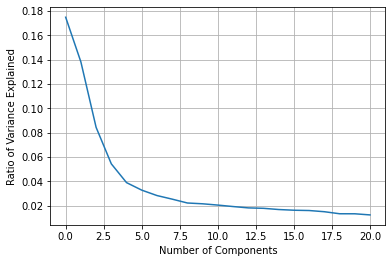

In [58]:
# Plot the transformed dataframe.
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Ratio of Variance Explained')
plt.grid();


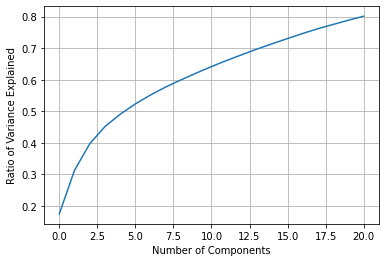

In [59]:
# Plot the transformed dataframe.
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Ratio of Variance Explained')
plt.grid();


In [60]:
# Print the new variance ratio.
print('Print the new variance ratio: ', "\n")
print(pca.explained_variance_ratio_)


Print the new variance ratio:  

[0.17473992 0.1380691  0.084377   0.0544072  0.03900966 0.03283584
 0.02840224 0.02544588 0.02228852 0.02163312 0.02057644 0.01937833
 0.01827673 0.01792558 0.016933   0.01635834 0.0161151  0.01513104
 0.01346229 0.01343571 0.01250785]


### Discussion 2.2: Perform Dimensionality Reduction

I used 21 for the 'n_components' parameter and was able to reach a total of around 0.8 or 80% which should be enough to avoid overfitting.

### Step 2.3: Interpret Principal Components

Now that I have my transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, I will map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. I will use the data dictionary document to help me understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- I will investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, I  will write a function that I can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when I interpret the tendencies of the discovered clusters.

In [61]:
# Map weights for the principal components to corresponding column names.
def get_sorted_weights(i):

    column_weights = pd.Series(pca.components_[i], index=azdias.columns)
    
    azdias_weights = pd.DataFrame(column_weights.sort_values(), columns=['weights'])
    azdias_weights.reset_index(inplace=True)

    return azdias_weights.rename(columns={'index':'features'})

# Feature weights for the first principal component.
azdias_sorted_weights = get_sorted_weights(0)
print("Feature weights for the first principal component: ", "\n")
azdias_sorted_weights


Feature weights for the first principal component:  



,features,weights
0,MOBI_REGIO,-0.242114
1,PLZ8_ANTG1,-0.226300
2,KBA05_ANTG1,-0.225672
3,FINANZ_MINIMALIST,-0.218598
4,KBA05_GBZ,-0.217151
...,...,...
58,ORTSGR_KLS9,0.197280
59,HH_EINKOMMEN_SCORE,0.204194
60,CAMEO_INTL_2015_WEALTH,0.207574
61,PLZ8_ANTG4,0.219816


In [62]:
# Feature weights for the second principal component.
print("Feature weights for the second principal component: ", "\n")
get_sorted_weights(1)


Feature weights for the second principal component:  



,features,weights
0,PRAEGENDE_JUGENDJAHRE_DECADE,-0.257492
1,SEMIO_REL,-0.251393
2,FINANZ_SPARER,-0.241740
3,SEMIO_TRADV,-0.236352
4,SEMIO_PFLICHT,-0.234126
...,...,...
58,RETOURTYP_BK_S,0.170507
59,SEMIO_LUST,0.186757
60,SEMIO_ERL,0.220629
61,FINANZ_VORSORGER,0.238490


In [63]:
# Feature weights for the third principal component.
print("Feature weights for the third principal component: ", "\n")
get_sorted_weights(2)


Feature weights for the third principal component:  



,features,weights
0,SEMIO_KAEM,-0.367327
1,SEMIO_DOM,-0.343017
2,SEMIO_KRIT,-0.307544
3,SEMIO_RAT,-0.212175
4,SEMIO_ERL,-0.209770
...,...,...
58,FINANZ_MINIMALIST,0.164341
59,SEMIO_KULT,0.268364
60,SEMIO_FAM,0.284633
61,SEMIO_SOZ,0.294091


### Discussion 2.3: Interpret Principal Components
Interpretation of positive & negative values of the first principal component:
The negative values are weighted towards movement patterns and a low number of family houses, and the positive values are weighted towards a higher number of family houses and wealthy households.

Interpretation of positive & negative values of the second principal component:
The negative values are weighted towards any given decade, religious type, and money saver financial type, and the positive values are weighted towards personality types who are event oriented. 

Interpretation of positive & negative values of the third principal component:
The negative values are weighted towards personality types of combative, dominant, critical. and the positive values are weighted towards personality types of family oriented, social, dreamful.





## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

I've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, I will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- I will use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, I will compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. I will apply it to a small, toy dataset, or use an internet search to help my understanding.
- I will perform the above two steps for a number of different cluster counts. Then I can see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit.  I will use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take.  I should test for cluster counts through at least 10 clusters to get the full picture, but I shouldn't need to test for a number of clusters above about 30.
- Once I've selected a final number of clusters to use, I will re-fit a KMeans instance to perform the clustering operation. I will make sure that I also obtain the cluster assignments for the general demographics data, since I'll be using them in the final Step 3.3.

In [64]:
# Run KMeans over a number of different cluster counts.

""" 
from sklearn.cluster import KMeans

def calculate_kmeans_score(data, k):

    kmeans = KMeans(n_clusters=k)
    k_model = kmeans.fit(data)
    k_score = np.abs(k_model.score(data))

    return k_score  

k_scores = []    
    
n_clusters = [x for x in range(10, 30, 2)]    
for k in n_clusters:
  k_scores.append(calculate_kmeans_score(azdias_pca, k))    

print("Print k_scores: ", "\n")
print(k_scores) 
"""


' \nfrom sklearn.cluster import KMeans\n\ndef calculate_kmeans_score(data, k):\n\n    kmeans = KMeans(n_clusters=k)\n    k_model = kmeans.fit(data)\n    k_score = np.abs(k_model.score(data))\n\n    return k_score  \n\nk_scores = []    \n    \nn_clusters = [x for x in range(10, 30, 2)]    \nfor k in n_clusters:\n  k_scores.append(calculate_kmeans_score(azdias_pca, k))    \n\nprint("Print k_scores: ", "\n")\nprint(k_scores) \n'

In [65]:
# Plot the k_scores in relation to sum of squared errors and n_clusters.

"""
plt.plot(n_clusters, k_scores, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squared errors")
plt.xticks(n_clusters)
plt.grid()
plt.title('SSE relationship to Clusters');
"""


'\nplt.plot(n_clusters, k_scores, marker=\'o\')\nplt.xlabel("Number of clusters")\nplt.ylabel("Sum of squared errors")\nplt.xticks(n_clusters)\nplt.grid()\nplt.title(\'SSE relationship to Clusters\');\n'

In [66]:
# Re-fit the model with 18 n_clusters.
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=18, init="random", random_state=0)
kmodel = kmeans.fit(azdias_pca)


General labels: 
[ 4  7  5 ...  3 17 10] 

Unique labels: 
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] 



/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


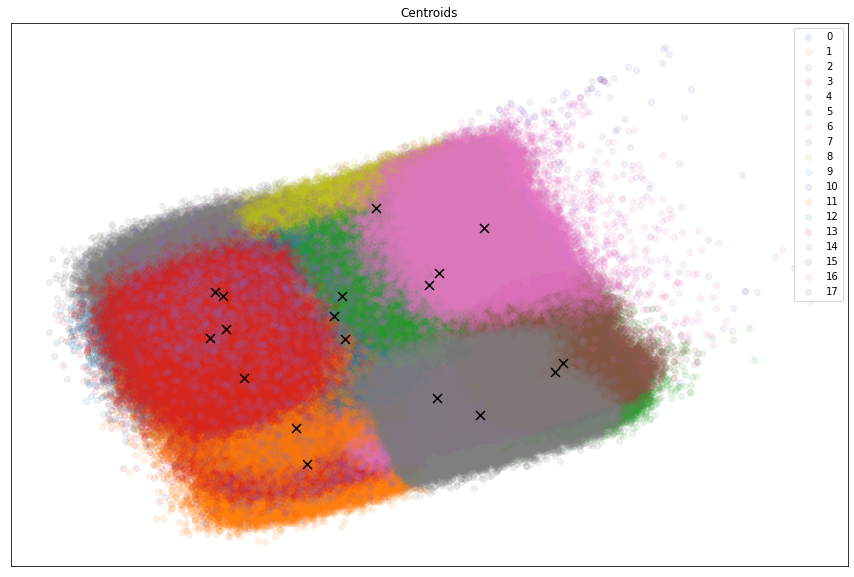

In [67]:
from enum import unique
# Get and plot model predictions.
general_labels = kmodel.predict(azdias_pca)
print("General labels: ")
print(general_labels, "\n")

unique_labels = np.unique(general_labels)
print("Unique labels: ")
print(unique_labels, "\n")

plt.figure(figsize=[15, 10])

for i in unique_labels:

    plt.scatter(azdias_pca[general_labels == i, 0], azdias_pca[general_labels == i, 1], label = i, alpha=0.1)  

centroids = kmodel.cluster_centers_

plt.scatter(centroids[:,0], centroids[:,1], s=80, color='black', marker='x')
plt.title('Centroids')
plt.xticks(())
plt.yticks(())
plt.legend();


### Discussion 3.1: Apply Clustering to General Population

I used the elbow-method on the plot where I used many n_clusters in a range between 10 and 30 skipping 2 each time.

The n_cluster number I chose was 18.

Then I fit the model on the data and got predictions which I then plotted with 18 centroids.


### Step 3.2: Apply All Steps to the Customer Data

Now that I have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, I am going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, I will interpret how the general population fits apply to the customer data.

- I won't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- I will apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function I created earlier. (I can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- I will use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, I should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should I be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [68]:
# Print the customer demographics data.
print("Print the customers demographic data file: ", "\n")
udacity


Print the customers demographic data file:  



,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191647,1,3,1,4.0,5,1,5,1,1,2,...,2.0,4.0,2.0,1.0,2.0,5.0,4.0,3.0,8.0,5.0
191648,-1,4,2,2.0,5,1,5,2,2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,1.0
191649,2,4,1,2.0,5,1,5,1,1,2,...,3.0,2.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0
191650,3,3,2,4.0,2,1,5,1,2,5,...,3.0,2.0,1.0,1.0,1.0,2.0,3.0,3.0,4.0,4.0


In [69]:
# Preprocess & clean the udacity dataset.
udacity = clean_data(udacity)
print("Print cleaned udacity dataset: ", "\n")
udacity


The contents of i:  0 

The contents of category:  AGER_TYP 

The contents of missing data list:  ['-1', '0'] 

The contents of j:  0 

The contents of j:  1 

The final missing list contents:  [-1, 0] 
 

The contents of i:  1 

The contents of category:  ALTERSKATEGORIE_GROB 

The contents of missing data list:  ['-1', '0', '9'] 

The contents of j:  0 

The contents of j:  1 

The contents of j:  2 

The final missing list contents:  [-1, 0, 9] 
 

The contents of i:  2 

The contents of category:  ANREDE_KZ 

The contents of missing data list:  ['-1', '0'] 

The contents of j:  0 

The contents of j:  1 

The final missing list contents:  [-1, 0] 
 

The contents of i:  3 

The contents of category:  CJT_GESAMTTYP 

The contents of missing data list:  ['0'] 

The contents of j:  0 

The final missing list contents:  [0] 
 

The contents of i:  4 

The contents of category:  FINANZ_MINIMALIST 

The contents of missing data list:  ['-1'] 

The contents of j:  0 

The final missing li

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,4.0,NaN,5,1,5,1,2,2,1,1.0,...,0.0,5.0,5.0,1.0,2.0,1.0,1.0,1.0,1.0,3.0
2,4.0,1.0,5,1,5,1,4,4,1,2.0,...,1.0,3.0,2.0,3.0,5.0,3.0,1.0,1.0,3.0,4.0
3,4.0,NaN,5,1,5,2,1,2,0,2.0,...,0.0,3.0,4.0,1.0,3.0,1.0,0.0,0.0,2.0,4.0
4,3.0,NaN,3,1,4,4,5,2,0,3.0,...,1.0,3.0,3.0,3.0,5.0,1.0,0.0,3.0,4.0,1.0
5,3.0,NaN,5,1,5,1,2,3,1,3.0,...,1.0,5.0,5.0,3.0,7.0,5.0,1.0,1.0,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191646,2.0,1.0,2,1,5,1,2,5,0,2.0,...,0.0,1.0,1.0,3.0,9.0,5.0,0.0,3.0,1.0,4.0
191647,3.0,NaN,5,1,5,1,1,2,1,3.0,...,1.0,5.0,4.0,3.0,8.0,5.0,1.0,1.0,1.0,4.0
191649,4.0,NaN,5,1,5,1,1,2,1,2.0,...,1.0,5.0,5.0,3.0,7.0,5.0,1.0,1.0,2.0,4.0
191650,3.0,1.0,2,1,5,1,2,5,0,2.0,...,1.0,2.0,3.0,3.0,4.0,4.0,0.0,3.0,2.0,4.0


In [70]:
print(udacity)

        ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                        4.0        NaN                  5              1   
2                        4.0        1.0                  5              1   
3                        4.0        NaN                  5              1   
4                        3.0        NaN                  3              1   
5                        3.0        NaN                  5              1   
...                      ...        ...                ...            ...   
191646                   2.0        1.0                  2              1   
191647                   3.0        NaN                  5              1   
191649                   4.0        NaN                  5              1   
191650                   3.0        1.0                  2              1   
191651                   2.0        NaN                  5              1   

        FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
0       

In [71]:
udacity.select_dtypes(include=['object']).columns

Index([], dtype='object')

In [72]:
# Transform the udacity customer dataset.

# Imputation.
print("NaN values before imputing: {}".format(udacity.isnull().sum().sum()))

udacity_imputed = pd.DataFrame(imp_mean.transform(udacity))
udacity_imputed.columns = udacity.columns
udacity_imputed.index = udacity.index
udacity = udacity_imputed

print("NaN values after imputing: {}".format(udacity.isnull().sum().sum()))


NaN values before imputing: 162852
NaN values after imputing: 0


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- PRAEGENDE_JUGENDJAHRE_MOVEMENT 
Feature names seen at fit time, yet now missing:
- PRAEGENDE_JUGENDJAHRE_MOVEMENT

  warnings.warn(message, FutureWarning)


In [73]:
# Print imputed udacity dataset.
print("Print imputed udacity dataset: ", "\n")
udacity


Print imputed udacity dataset:  



,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,0.0,5.0,5.0,1.0,2.0,1.0,1.0,1.0,1.0,3.0
2,4.0,1.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,...,1.0,3.0,2.0,3.0,5.0,3.0,1.0,1.0,3.0,4.0
3,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,3.0,4.0,1.0,3.0,1.0,0.0,0.0,2.0,4.0
4,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,...,1.0,3.0,3.0,3.0,5.0,1.0,0.0,3.0,4.0,1.0
5,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,1.0,5.0,5.0,3.0,7.0,5.0,1.0,1.0,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191646,2.0,1.0,2.0,1.0,5.0,1.0,2.0,5.0,0.0,2.0,...,0.0,1.0,1.0,3.0,9.0,5.0,0.0,3.0,1.0,4.0
191647,3.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,1.0,3.0,...,1.0,5.0,4.0,3.0,8.0,5.0,1.0,1.0,1.0,4.0
191649,4.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,1.0,2.0,...,1.0,5.0,5.0,3.0,7.0,5.0,1.0,1.0,2.0,4.0
191650,3.0,1.0,2.0,1.0,5.0,1.0,2.0,5.0,0.0,2.0,...,1.0,2.0,3.0,3.0,4.0,4.0,0.0,3.0,2.0,4.0


In [74]:
# Transform the udacity customer dataset.

# Scaling.
print("Scale the udacity dataset: ", "\n")

udacity_scaled = pd.DataFrame(scaler.transform(udacity))
udacity_scaled.columns = udacity.columns
udacity_scaled.index = udacity.index
udacity = udacity_scaled

print("Print scaled udacity dataset: ", "\n")
udacity


Scale the udacity dataset:  

Print scaled udacity dataset:  



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- PRAEGENDE_JUGENDJAHRE_MOVEMENT 
Feature names seen at fit time, yet now missing:
- PRAEGENDE_JUGENDJAHRE_MOVEMENT

  warnings.warn(message, FutureWarning)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,1.181706,0.0,1.414618,-1.151087,1.133828,-1.247812,-0.454983,-0.817895,1.882535,-1.630686,...,-0.96719,1.432164,1.464792,-2.186565,-1.439894,-1.533367,1.873182,-1.621097,-1.555547,0.087097
2,1.181706,0.0,1.414618,-1.151087,1.133828,-1.247812,0.980071,0.611953,1.882535,-0.276116,...,0.41488,-0.632762,-1.247980,-0.175058,-0.133526,-0.058279,1.873182,-1.621097,-0.187611,0.760774
3,1.181706,0.0,1.414618,-1.151087,1.133828,-0.569041,-1.172510,-0.817895,-0.531199,-0.276116,...,-0.96719,-0.632762,0.560535,-2.186565,-1.004438,-1.533367,-0.552603,-2.318741,-0.871579,0.760774
4,0.198771,0.0,-0.036761,-1.151087,0.407468,0.788502,1.697599,-0.817895,-0.531199,1.078455,...,0.41488,-0.632762,-0.343723,-0.175058,-0.133526,-1.533367,-0.552603,-0.225811,0.496357,-1.260258
5,0.198771,0.0,1.414618,-1.151087,1.133828,-1.247812,-0.454983,-0.102971,1.882535,1.078455,...,0.41488,1.432164,1.464792,-0.175058,0.737385,1.416808,1.873182,-1.621097,-0.187611,0.760774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191646,-0.784164,0.0,-0.762450,-1.151087,1.133828,-1.247812,-0.454983,1.326876,-0.531199,-0.276116,...,-0.96719,-2.697688,-2.152238,-0.175058,1.608297,1.416808,-0.552603,-0.225811,-1.555547,0.760774
191647,0.198771,0.0,1.414618,-1.151087,1.133828,-1.247812,-1.172510,-0.817895,1.882535,1.078455,...,0.41488,1.432164,0.560535,-0.175058,1.172841,1.416808,1.873182,-1.621097,-1.555547,0.760774
191649,1.181706,0.0,1.414618,-1.151087,1.133828,-1.247812,-1.172510,-0.817895,1.882535,-0.276116,...,0.41488,1.432164,1.464792,-0.175058,0.737385,1.416808,1.873182,-1.621097,-0.871579,0.760774
191650,0.198771,0.0,-0.762450,-1.151087,1.133828,-1.247812,-0.454983,1.326876,-0.531199,-0.276116,...,0.41488,-1.665225,-0.343723,-0.175058,-0.568982,0.679265,-0.552603,-0.225811,-0.871579,0.760774


In [75]:
# Apply PCA techniques to the udacity dataset.
print("Apply PCA to the udacity dataset.", "\n")

udacity_pca = pca.transform(udacity)

print("\n")
print("Print the PCA transformed udacity dataset: ", "\n")
udacity_pca


Apply PCA to the udacity dataset. 



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- PRAEGENDE_JUGENDJAHRE_MOVEMENT 
Feature names seen at fit time, yet now missing:
- PRAEGENDE_JUGENDJAHRE_MOVEMENT

  warnings.warn(message, FutureWarning)




Print the PCA transformed udacity dataset:  



array([[-5.83715044,  1.14635886,  4.19285606, ...,  0.02271256,
         0.28670533,  1.32198284],
       [-1.62932179,  4.76519616, -0.67892969, ..., -1.35152689,
        -0.48824225, -0.5281527 ],
       [-4.31438466,  0.53868627,  2.42066514, ..., -0.09875823,
        -0.85325476, -0.40791443],
       ...,
       [-4.43945303,  2.87424888,  2.0064174 , ..., -0.07475851,
        -0.26917021, -1.01464782],
       [-1.01395746,  2.58896956, -1.97540055, ...,  0.02488359,
         0.01827024, -1.63747238],
       [-3.60074906, -2.51394968,  2.32914633, ...,  0.47093517,
         0.41736026,  1.02097286]])

Customer labels: 
[ 0  7 13 ...  0  5 13] 

Unique labels: 
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] 



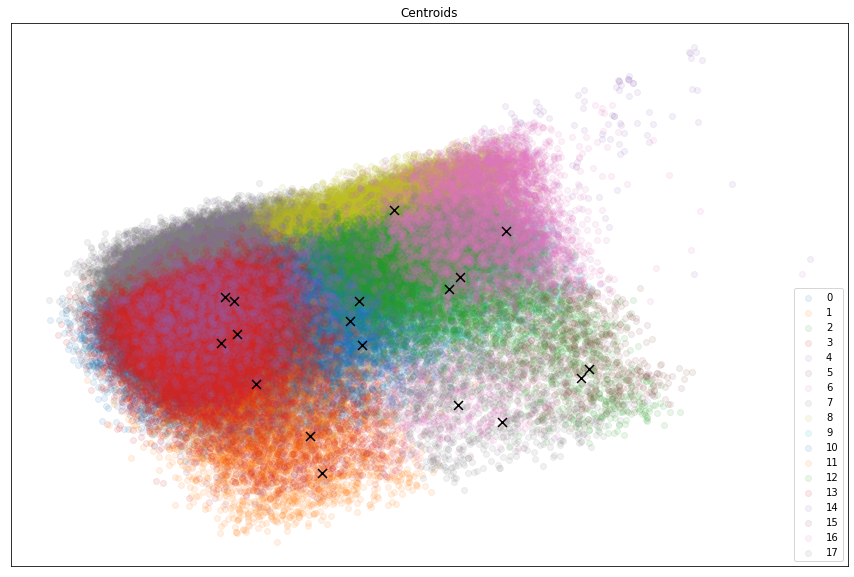

In [76]:
# Apply clustering to transformed udacity dataset.  
customer_labels = kmodel.predict(udacity_pca)
print("Customer labels: ")
print(customer_labels, "\n")

unique_labels = np.unique(customer_labels)
print("Unique labels: ")
print(unique_labels, "\n")

# Get and plot model predictions.
plt.figure(figsize=[15, 10])

for i in unique_labels:

    plt.scatter(udacity_pca[customer_labels == i, 0], udacity_pca[customer_labels == i, 1], label = i, alpha=0.1)

centroids = kmodel.cluster_centers_

plt.scatter(centroids[:,0], centroids[:,1], s=80, color='black', marker='x')
plt.title('Centroids')
plt.xticks(())
plt.yticks(())
plt.legend();


### Step 3.3: Compare Customer Data to Demographics Data

At this point, I have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, I will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If I think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then I should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

 I will take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis I performed in step 1.1.3 of the project, where I separated out certain data points from the dataset if they had more than a specified threshold of missing values. If I find that this group was qualitatively different from the main bulk of the data, I should treat this as an additional data cluster in this analysis.  I will make sure that I account for the number of data points in this subset, for both the general population and customer datasets, when making my computations.
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? I will select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, I can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Print azdias proportions:  

Print udacity proportions:  

Print azdias proportions:  

Print udacity proportions:  

Print azdias proportions:  

Print udacity proportions:  

Print azdias proportions:  

Print udacity proportions:  

Print azdias proportions:  

Print udacity proportions:  

Print azdias proportions:  

Print udacity proportions:  

Print azdias proportions:  

Print udacity proportions:  

Print azdias proportions:  

Print udacity proportions:  

Print azdias proportions:  

Print udacity proportions:  

Print azdias proportions:  

Print udacity proportions:  

Print azdias proportions:  

Print udacity proportions:  

Print azdias proportions:  

Print udacity proportions:  

Print azdias proportions:  

Print udacity proportions:  

Print azdias proportions:  

Print udacity proportions:  

Print azdias proportions:  

Print udacity proportions:  

Print azdias proportions:  

Print udacity proportions:  

Print azdias proportions:  

Print udacity proportions: 

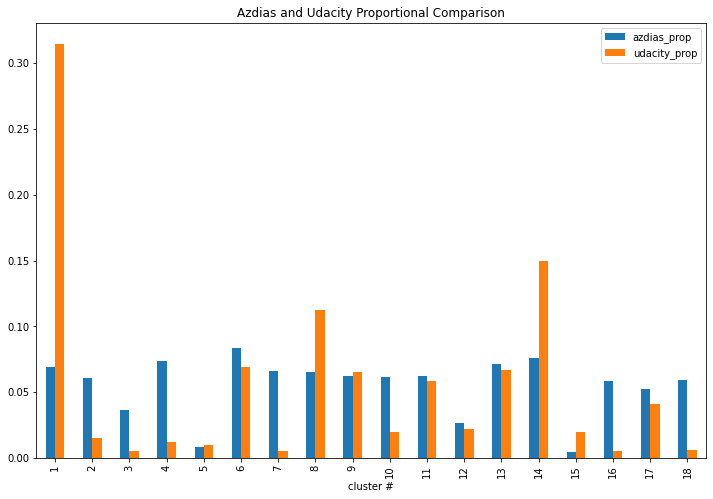

In [78]:
from IPython.core.pylabtools import figsize
# Compare the proportion of data in each cluster for the udacity data to the
# proportion of data in each cluster for the azdias data.
azdias_prop = []
udacity_prop = []

for i in range(0, 18):

    azdias_prop.append((general_labels == i).sum() / len(general_labels))
    print("Print azdias proportions: ", "\n")
    azdias_prop

    udacity_prop.append((customer_labels == i).sum() / len(customer_labels))
    print("Print udacity proportions: ", "\n")
    udacity_prop

clusters = [k+1 for k in range(18)]
print("Print clusters: ", "\n")
clusters

proportion_df = pd.DataFrame({'cluster #' : clusters, 'azdias_prop' : azdias_prop, 'udacity_prop' : udacity_prop})
print("Print proportion dataframe: ", "\n")
proportion_df

proportion_df.plot(x='cluster #', y=['azdias_prop', 'udacity_prop'], kind='bar', figsize=(12, 8));
plt.ylabel=('% of total')
plt.title('Azdias and Udacity Proportional Comparison'); 


In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.